<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/preparingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SENTIMENT ANALYSIS**

# Set-Up


## Kaggle's API

In [43]:
!pip install -q kaggle
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"jjordana16","key":"6e806145f7c3fdd4c09e7299f3a70d73"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [45]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content

- path is now set to: /content


In [46]:
!kaggle competitions download -c tweet-sentiment-extraction

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## Importing Libraries & data

In [137]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import random
import re, string
import time

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet') # For the counterPlots

## Used for creating the words graphs
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

# Listing all the files in our folder
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
test = pd.read_csv('/content/competitions/tweet-sentiment-extraction/test.csv')
train = pd.read_csv('/content/competitions/tweet-sentiment-extraction/train.csv.zip')

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [147]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


# EDA & FEAUTRE ENGINEERING


Our first main target is going to be the analysis of all our tweets data. We are going to focus first on the `training set`.<br>

We have distinguish three types of sentiments: `positive`, `neutral`, and `negative`. <br> The main aim of this [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction) is to get the words that have the highest weight for deciding the sentiment of a tweet. Therefore, the sentiment has already been stablished, we do not need to get it.<br>
However, I found crucial to understand how `sentiment analysis` works before going on a further level.

In our `training data`, `neutral` tweets are the most common ones, followed by `positive`tweets. Let's try to plot which are the most common words in all these three types of text.

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Train Sentiment Count')

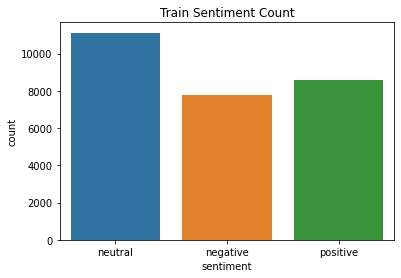

In [51]:
sentiments = ['positive', 'neutral', 'negative']
print(train['sentiment'].value_counts())
sns.countplot(x='sentiment', data=train).set_title('Train Sentiment Count')

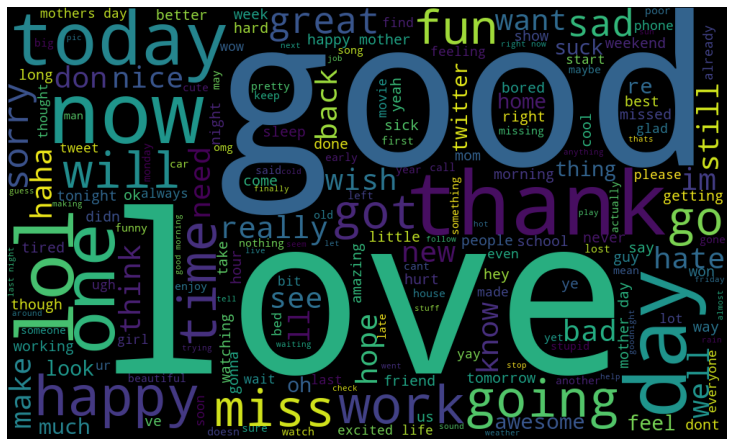

In [52]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train['selected_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Words such as _love, good, thank_ seem to be the most common in all our data. However, trying to plot a `worcloud` with all the *selected_text* is useless. It is more acurrate to work separetly with all the different sentiments. 

We can split our oirginal dataste into three subdatasets, differentiated by the sentiment. <br> After having all the data splitted we can now study sentiment by sentiment.

NPL processes deal with text chains. This chains need to be trasnformed. <br> Firstly, we are going to split our tweets into `tokens`, sets of words. After this, `lemmatization`much be the following step. In this part, we will get the root of the word _(i.e the root for **player** is play)_.

But, before performing any of these steps, we must **clean** firstly our data. I consider this part the most important one. <br> Keep in mind that we are dealing with **tweets**!! Here anyone can write in any particular way. There are no rules. For sure our texts are full of special character `[?!,:),:(&]`, links and so on. We need to try to homogenize our data as much as possible.<br>
Besides, we are going to try to solve those spelling imperfections such as _heeeeello_. Here, you can see that the letter **e** is repeated several times. Although we know that means __hello__, the code is going to treat it as a different word. We will try to fix this by trying to replace any `vocal` or common letter (i.e `n, r, s, l`) that is repeated more than three time.


In [0]:
def cleaningText(df, column):
  # Removing special characters
  for val in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", 
    ";", "%", "$", "@", "%", "^", "*", "(", ")", "{", "}", "[", "]", "|", "/", 
    "\\", ">", "<", "-", "!", "?", ".", "'", "_", "--", "---", "#"]):
    df[column] = df[column].str.replace(re.compile(val), "")

  # Removing urls
  df[column] = df[column].replace('http\S[a-z0-9]+', '', regex=True)

  return df

In [0]:
 # Removing repeated letters
def controlLetters(x):
    text = x
    for letter in ['a', 'e', 'i', 'o', 'u', 'r', 'l', 'n', 's', 'm']:
    # for letter in ['e', 'l', 'o']:
        key = str(letter*3) + '+'
        if len(re.findall(key, text)) > 0:
            text = re.sub((str(letter*3) + '+'), letter, text)
        
    return text
  

In [0]:
# For the tweet text
train['newText'] = train['text'].str.lower()
train = cleaningText(train, 'newText')
train['newText'] = train['newText'].apply(controlLetters)

# For the selected_text
train['newSelection'] = train['selected_text'].str.lower()
train = cleaningText(train, 'newSelection')
train['newSelection'] = train['newSelection'].apply(controlLetters)

Now that we have cleaned our text, lets perfomr our tokenization and lemmatization.<br>
We will plot all our data so we can understand easily the top words.

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [57]:
def counterPlot(df, columns):
  # Creating the Chart
  def horizontal_bar_chart(df, color):
      trace = go.Bar(
          y=df["word"].values[::-1],
          x=df["wordcount"].values[::-1],
          showlegend=False,
          orientation = 'h',
          marker=dict(color=color, ),)
      return trace

  result = []
  dictio = []
  for val in range(0, 3):
    freq_dict = defaultdict(int)
    for tweet in df[df['sentiment']==columns[val]]['newSelection']:
        for word in lemmatization(tokenization(tweet)):
            freq_dict[word] += 1

    colors = ['green', 'orange', 'red']
    # Building graph for our dictionary
    df_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    df_sorted.columns = ["word", "wordcount"]
    trace = horizontal_bar_chart(df_sorted.head(50), colors[val])
    result.append(trace)
    dictio.append(freq_dict)

  # Creating two subplots
  fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                          subplot_titles=["Positive frequent words", 'Neutral frequent words', 'Negative frequent words'])
  
  i = 1
  for val in result:
    fig.append_trace(val, 1, i)
    i += 1

  fig['layout'].update(height=1000, width=900, paper_bgcolor='rgb(233,233,233)', title="TOP WORDS")

  return py.iplot(fig, filename='word-plots'), dictio

wordList = counterPlot(train, sentiments)
wordList[0]

In [0]:
# Provides de TOP 50 words for specific sentiment
def sentimentTopWords(sentiment):
  val = sentiments.index(sentiment)

  df = pd.DataFrame.from_dict(wordList[1][val], orient='index')
  df['word'] = df.index
  df['count'] = df[0]
  df = df.reset_index().drop(columns=[0, 'index']).sort_values(by='count', ascending=False).head(120)
  return list(df['word'])

In [59]:
! pip install matplotlib-venn-wordcloud

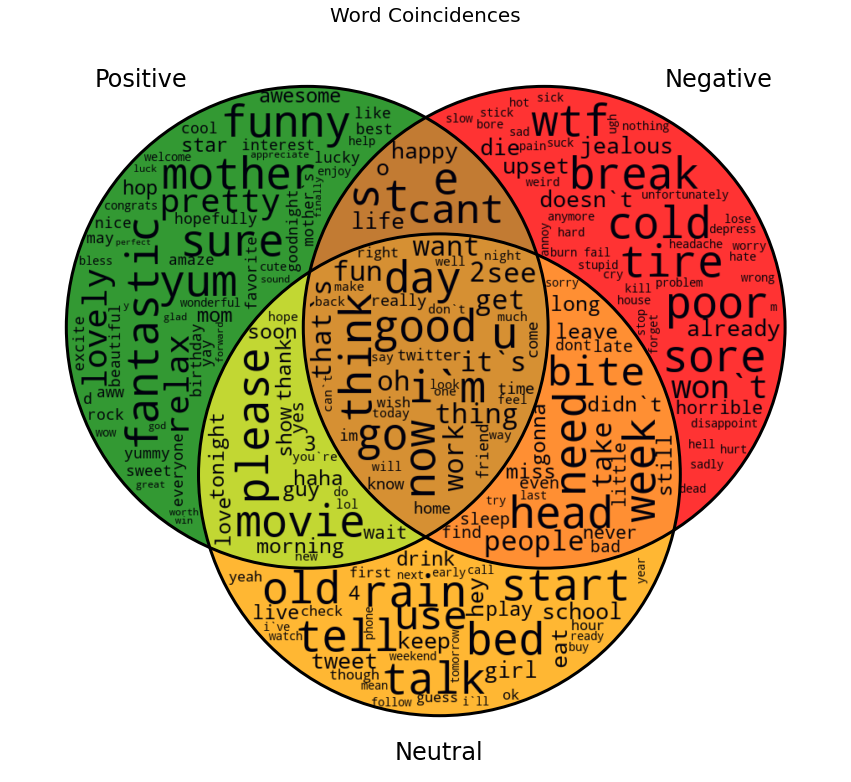

In [60]:
from matplotlib_venn_wordcloud import venn3_wordcloud

fig, ax = plt.subplots(figsize = (15,15))
ax.set_title('Word Coincidences', fontsize=20)
v = venn3_wordcloud([set(sentimentTopWords('positive')), set(sentimentTopWords('negative')), set(sentimentTopWords('neutral'))],
          set_labels=['Positive', 'Negative', 'Neutral'], ax=ax, set_colors=['green', 'red', 'orange'])

Both graphs provides us a good idea about which are the words most repeated for each sentiment, and which of them are common between different sentiments. Obvisouly, those words that belong to a specific sentiment are always going to be less _problematic_ than those mixed.

Now we have some idea about which are the most common words between sentiments. Let's focus on the _selected_text_. This column represents our target. Those are the words that after all our process we want to achieve. Let's try to analyze the similartity of _selected_text_ with respect the main tweet (we will analyze our `newSelection` as it has been already tokenized and lemmatized). This calculus is called [`jaccard similarity`](https://deepai.org/machine-learning-glossary-and-terms/jaccard-index), and I found it very interesting on [Mr_KnowNothing's kernell](https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model).


In [0]:
def jaccardScore(a, b):
  a = lemmatization(tokenization(a))
  b = lemmatization(tokenization(b))
  
  try:
    intersect = list(set(a).intersection(b)) # Common values between A and B
    union = len(a) + len(b) - len(intersect) # Values of A and B witout commons
    return round((len(intersect) / union), 2)
  except: # For those cases in which our tweet is mainly composed of STOPWORDS
    return 1

In [0]:
train['jaccScore'] = train.apply(lambda x: jaccardScore(x.newText, x.newSelection), axis=1)

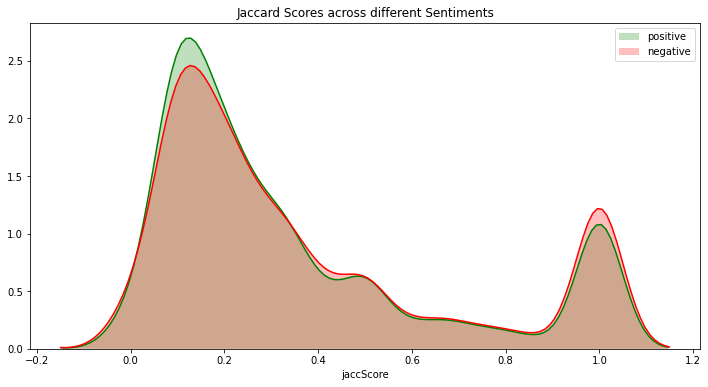

In [63]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)

plt.legend(labels=['positive','negative'])

We have only focused on `positive` and `negative` sentiments because the majority of neutral tweet have either a lot of difference or lot of similarity (the are not intermediate values and therefore the scale does not help to visualize the data).

In [154]:
# For the tweet text
test['newText'] = test['text'].str.lower()
test = cleaningText(test, 'newText')
test['newText'] = test['newText'].apply(controlLetters)

print('TRAIN LENGTH ', len(train))
print('TEST LENGTH ', len(test))

TRAIN LENGTH  27480
TEST LENGTH  3534


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

from textblob import TextBlob

In [0]:
train_data = train[['newText', 'sentiment']]
train_data['sentimentCode'] = le.fit_transform(train_data['sentiment'].values) # 1 neutral, 0 negative, 2 positive

In [156]:
# Count and print the number of duplicates
duplicate_indices = train_data.loc[train_data.duplicated(keep='first')].index

print('Number of duplicates in the dataset: {}'.format(train_data.loc[duplicate_indices, 'newText'].count()))
train_data.loc[duplicate_indices, :].sort_values(by=['newText']).head()

Number of duplicates in the dataset: 163


,newText,sentiment,sentimentCode
14948,square b she is sad because she wasn`t ther...,negative,0
25553,square b she is sad because she wasn`t ther...,negative,0
22684,thanks,positive,2
10363,thanks,positive,2
23660,why,neutral,1


In [0]:
#Removing duplicates
train_data.drop_duplicates(keep='first', inplace=True)

In [157]:
test_data = test[['newText', 'sentiment']]
test_data['sentimentCode'] = le.fit_transform(test_data['sentiment'].values) # 1 neutral, 0 negative, 2 positive
duplicate_indices = test_data.loc[test_data.duplicated(keep='first')].index

print('Number of duplicates in the dataset: {}'.format(test_data.loc[duplicate_indices, 'newText'].count()))
test_data.loc[duplicate_indices, :].sort_values(by=['newText']).head()
test_data.drop_duplicates(keep='first', inplace=True)

Number of duplicates in the dataset: 7


We have cleanned a little bit more our dataset. 

After reading [Radoslawkrolikowski's repository](https://https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch/blob/master/1_data_processing.ipynb) I have found interesting to add certain parameters performing a new `feature engineering`. These parameters are:<br>
`Polarity Score`: calculates a score for describing weather the sentiment is negative (-1), netural (0) or positive (+1).<br>
`Subjectivity`: a float that indicates weather the tweet is objective (0) or subjective (1).

In [0]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [0]:
train_data['polarityScore'] = train_data['newText'].apply(polarity)
train_data['subjectivity'] = train_data['newText'].apply(subjectivity)

test_data['polarityScore'] = test_data['newText'].apply(polarity)
test_data['subjectivity'] = test_data['newText'].apply(subjectivity)

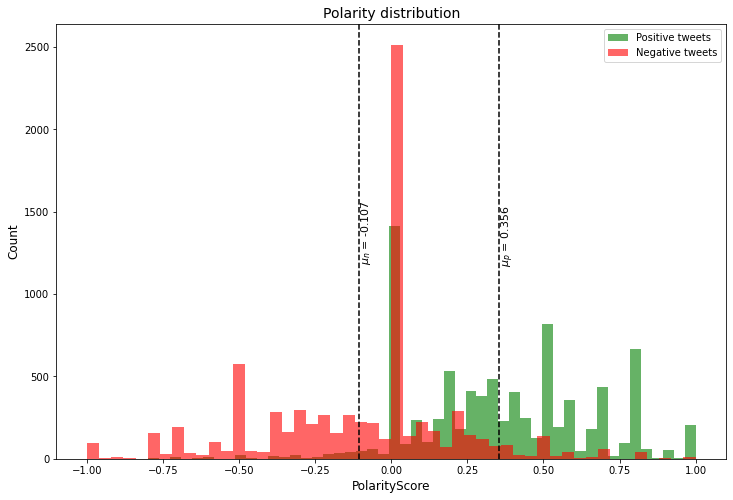

In [160]:
# Create a new figure
plt.figure(figsize=(12,8))

# Create a histogram of polarity 
plt.hist(train_data[train_data['sentimentCode'] == 2]['polarityScore'], bins=50, label='Positive tweets', alpha=0.6, color='green')
plt.hist(train_data[train_data['sentimentCode'] == 0]['polarityScore'], bins=50, label='Negative tweets', alpha=0.6, color='red')
# plt.hist(train_data[train_data['sentiment'] == 1]['polarityScore'], bins=50, label='Neutral tweets', alpha=0.6, color='orange')

# Create the title, horizontal axis label, vertical axis label and legend for the histograms
plt.title('Polarity distribution', size=14)
plt.xlabel('PolarityScore', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

# Calculate the mean value of polarity for positive and negative reviews
positiveMean = train_data[train_data['sentimentCode'] == 2]['polarityScore'].mean()
negativeMean = train_data[train_data['sentimentCode'] == 0]['polarityScore'].mean()
# neutralMean = train_data[train_data['sentiment'] == 1]['polarityScore'].mean()

# Add vertical lines that represent the average polarity of each class
plt.axvline(positiveMean, c='k', linestyle='--', linewidth=1.5)
plt.axvline(negativeMean, c='k', linestyle='--', linewidth=1.5)
# plt.axvline(neutralMean, c='k', linestyle='--', linewidth=1.5)

# Add annotations
plt.text(positiveMean, 1200, r'$\mu_p$ = {:.3f}'.format(positiveMean), rotation=90, size=11)
plt.text(negativeMean, 1200, r'$\mu_n$ = {:.3f}'.format(negativeMean), rotation=90, size=11)
# plt.text(neutralMean, 1200, r'$\mu_n$ = {:.3f}'.format(neutralMean), rotation=90, size=11)

plt.show()

In [0]:
train_data = train_data[['newText', 'sentiment']]
train_data = train_data.set_index('newText')
test_data = test_data[['newText', 'sentiment']]
test_data = test_data.set_index('newText')

In [0]:
train_data.to_csv('/content/competitions/tweet-sentiment-extraction/train_data.csv')
# valid_data.to_csv('/content/competitions/tweet-sentiment-extraction/valid_data.csv')
test_data.to_csv('/content/competitions/tweet-sentiment-extraction/test_data.csv')

# MODEL

We have already analyzed a little bit our data. The next step is going to be to try to create a model that predicts our desired `selected words`. 

All the different neural networks, libraries...are usually prepared to predict the sentiment analysis of a specific text, not the key words. However, we can get some advantage of having to predict the sentiment analysis. Once we have predicted the sentiment, we can get which are the words that have the highest weight for determining wheather the tweet is positive or neutral. Therefore, those heavy words might be the ones that we want to select. 

I am goin to base all this part on an incredible repository that I found on github, [Bentrevett's explanation](https://github.com/bentrevett/pytorch-sentiment-analysis) about the effective use of `pytorch` for sentiment analysis. <br>
I deeply recommend to have a look on this repository as its explains whith lots of details how this NN works (I will not go on the details), as well as the one from [Radoslawkrolikowski](https://https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch/blob/master/1_data_processing.ipynb).

## Preparing data

In [0]:
import torch
from torchtext import data
from torchtext import datasets

In [0]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()

In [0]:
dataFields = [("newText", TEXT), ("sentiment", LABEL)]
train, test = data.TabularDataset.splits(path='/content/competitions/tweet-sentiment-extraction/', 
                                        train='train_data.csv', test='test_data.csv',
                                        skip_header=True, format='csv', fields=dataFields)

In [0]:
train_data, valid_data = train.split(random_state = random.seed(SEED))

In [207]:
print(f'Number of training examples: {len(train_data)}')
print(vars(test.examples[0]))

Number of training examples: 19236
{'newText': ['last', 'session', 'of', 'the', 'day', ' '], 'sentiment': 'neutral'}


In [174]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test)}')

Number of training examples: 19236
Number of validation examples: 8244
Number of testing examples: 3527


In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [193]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab.stoi)}")

Unique tokens in TEXT vocabulary: 22104
Unique tokens in LABEL vocabulary: 3


In [177]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7feb9e6fe7b8>, {'neutral': 0, 'positive': 1, 'negative': 2})


In [145]:
print(TEXT.vocab.freqs.most_common(20))

[(' ', 15525), ('i', 9821), ('to', 6968), ('the', 6251), ('a', 4833), ('my', 3799), ('and', 3535), ('you', 3333), ('it', 2872), ('is', 2846), ('in', 2628), ('for', 2560), ('of', 2218), ('me', 2019), ('so', 1992), ('on', 1990), ('that', 1914), ('have', 1834), ('but', 1624), ('  ', 1572)]


In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test), 
    batch_size = BATCH_SIZE,
    device = device, 
    sort_key=lambda x: len(x.newText), sort_within_batch=False, repeat=False)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [212]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,214,303 trainable parameters


In [225]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.5139, -1.2348,  0.1935,  ..., -1.0619,  0.6242,  0.6940],
        [ 1.0868, -0.2609, -0.0381,  ...,  0.1613, -1.0265,  0.1877],
        [-0.2145, -0.8545,  0.7499,  ...,  1.8453, -0.3554, -0.0309],
        ...,
        [ 0.1402,  1.3247, -0.4152,  ...,  0.0837, -0.2628,  0.4289],
        [-0.9944, -1.7791, -0.4176,  ...,  0.5608,  0.1696,  1.7167],
        [-1.3822, -0.8485,  0.6694,  ..., -0.3374,  2.0013,  1.7068]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        predictions = model(batch.newText)
        loss = criterion(predictions, batch.sentiment)
        acc = categorical_accuracy(predictions, batch.sentiment)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.newText)
            loss = criterion(predictions, batch.sentiment)
            acc = categorical_accuracy(predictions, batch.sentiment)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [236]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

RuntimeError: ignored

In [0]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Bibliography

[*I’m going on a (data) adventure! — Hobbit text analysis*](https://towardsdatascience.com/im-going-on-a-data-adventure-hobbit-text-analysis-a0a5cb116ed1)

[*Introduction to Natural Language Processing with the Beatles and Taylor Swift*](https://towardsdatascience.com/introduction-to-natural-language-processing-with-the-beatles-and-taylor-swift-2a06055cbc14)

[*NLTK Library*](https://www.nltk.org/api/nltk.sentiment.html)

[*POLARITY_SCORE example*](https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c)

[*How to perform Sentyment Analysis*](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)

[*Ven diagrams and Wordclouds in Python*](https://towardsdatascience.com/venn-diagrams-and-word-clouds-in-python-1012373b38ed)